# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your section lead.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

---

## Load data

In [2]:
df = pd.read_csv('data/mypersonality.csv')
# df = pd.read_csv('data/mypersonality_noprofanity.csv') # comment out above & uncomment this to use mypersonality_noprofanity.csv
df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

#### Create a new column called `status_length` that contains the length of each status:

In [3]:
df['status_length'] = df['STATUS'].apply(lambda x: len(x))
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11


#### Create a new column called `status_word_count` that contains the number of words in each status:

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [4]:
df['status_word_count'] = df['STATUS'].apply(lambda x: len(x.split()))
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11,3


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

#### Show the five longest and five shortest statuses based off of `status_word_count`:

In [5]:
df.sort_values(by='status_word_count').head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
8178,4bbb1f5843d9d6e8966dce58179f01de,157,2.55,2.65,4.0,2.95,4.05,n,n,y,n,y,07/13/09 01:27 PM,3,1
4170,dba5f5266d03dd6d4db084ad7dbc683c,"wed,.",1.55,2.45,3.5,3.40,4.50,n,n,n,n,y,09/02/09 05:32 AM,5,1
2016,c3f4b3e345cb6b032db2e0459d179db3,HOUSE!,2.45,4.00,3.8,2.80,4.25,n,y,y,n,y,10/13/09 12:00 AM,6,1
956,e6cdef6f475cce3023c5b715f8c9f110,Err:509,1.80,2.90,2.9,3.00,4.20,n,y,n,n,y,10/10/09 07:23 PM,7,1
4177,dba5f5266d03dd6d4db084ad7dbc683c,confused,1.55,2.45,3.5,3.40,4.50,n,n,n,n,y,09/04/09 02:18 AM,8,1


In [6]:
df.sort_values(by='status_word_count', ascending=False).head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
496,9a8cf1dcb2de1a8f70c4745a636bbb96,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ...",3.75,3.25,4.50,5.00,4.00,y,y,y,y,y,10/30/09 02:05 PM,413,89
6989,502db2fcfe26705ae16a46c5cb2ad2e5,"If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost this if your proud of who you are! x x",3.20,3.30,4.55,3.20,4.45,n,y,y,n,y,02/18/11 08:33 AM,384,85
5208,c85845b82e705a32f674757d8912df23,"can't believe it. I got the new Wii Fit Plus game, it has a lot of fun new games and features. However, after not using the wii fit for a few months we decided to do the fitness test stuff again. Me(since last time): +2.9 lbs, still a healthy weight and BMI, wii age 54. *PROPNAME*: -8.6lbs, reccommends a healthy weight of gaining 6lbs, wii age 32. On the positive side, I have lost 5 of the 8 l...",2.25,2.75,4.50,4.25,2.50,n,n,y,y,n,01/08/10 07:32 PM,426,84
7976,d7e500ad854a1b6ced39e53a525b8a6d,"""I said he's a fairy I do suppose//flyin thru the air in pantyhose//he may be very sexy or even cute//but he looks like a sucka in a blue and red suit//I said you need a man who's got finesse//& his whole name across his chest//he may be able to fly all thru the night//but can he rock a party til the early light//he can't satisfy you with his little worm//but I can bust you out w my Super sper...",3.25,4.25,2.75,2.00,3.75,n,y,n,n,n,10/21/09 10:39 PM,429,83
5680,1ece40ac9b657dea8c22a1fe58d3a6fe,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is pretty certain in his hurry, to miss. I never do.",3.50,1.75,4.75,3.00,4.25,n,n,y,n,y,12/07/09 04:07 AM,395,83


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

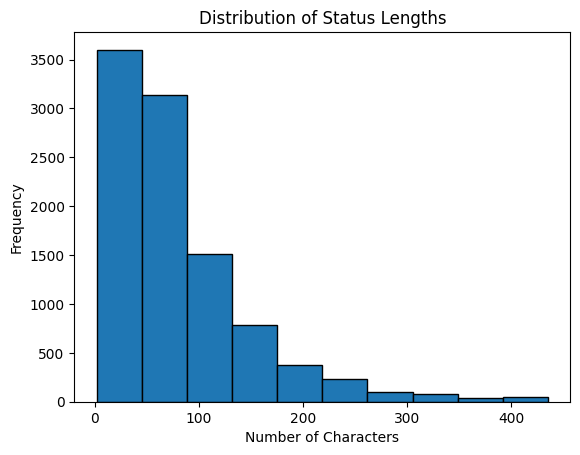

In [7]:
plt.hist(df['status_length'], bins=10, edgecolor='black')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Status Lengths')
plt.show()

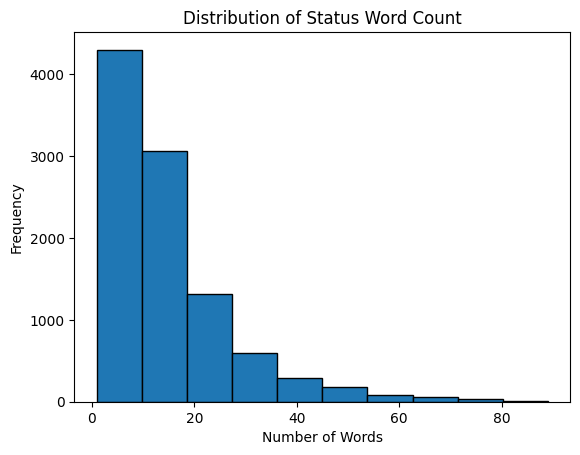

In [8]:
plt.hist(df['status_word_count'], bins=10, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Status Word Count')
plt.show()

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

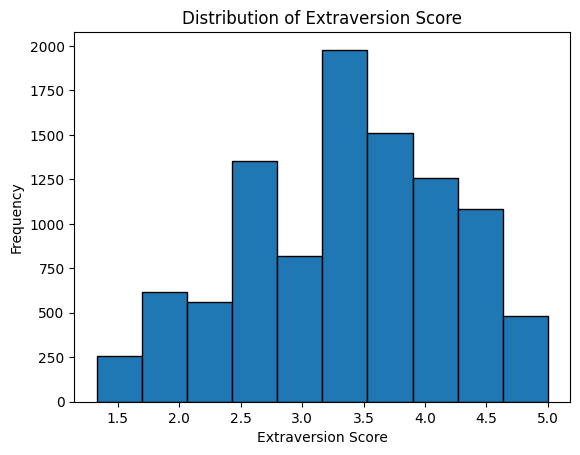

In [9]:
plt.hist(df['sEXT'], bins=10, edgecolor='black')
plt.xlabel('Extraversion Score')
plt.ylabel('Frequency')
plt.title('Distribution of Extraversion Score')
plt.show()

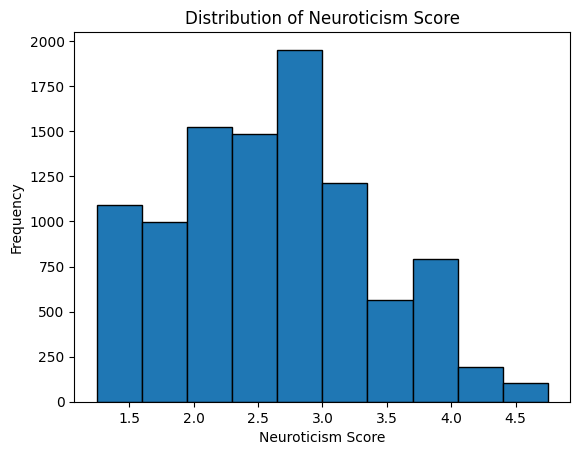

In [10]:
plt.hist(df['sNEU'], bins=10, edgecolor='black')
plt.xlabel('Neuroticism Score')
plt.ylabel('Frequency')
plt.title('Distribution of Neuroticism Score')
plt.show()

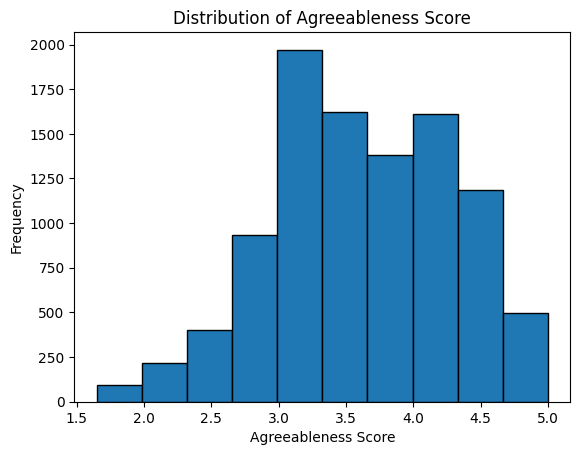

In [11]:
plt.hist(df['sAGR'], bins=10, edgecolor='black')
plt.xlabel('Agreeableness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Agreeableness Score')
plt.show()

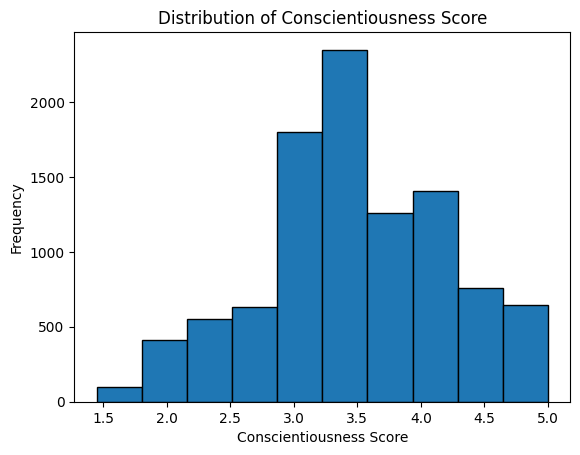

In [12]:
plt.hist(df['sCON'], bins=10, edgecolor='black')
plt.xlabel('Conscientiousness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Conscientiousness Score')
plt.show()

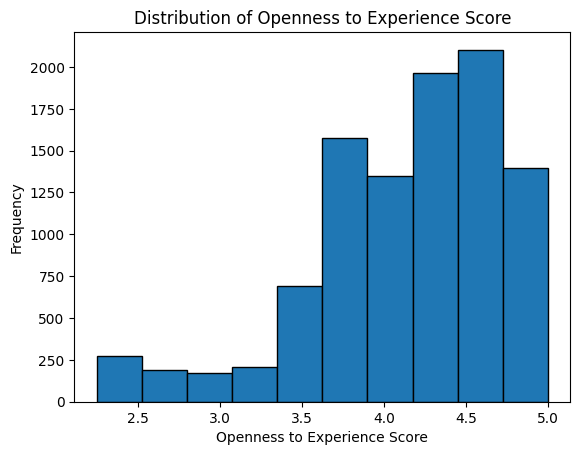

In [13]:
plt.hist(df['sOPN'], bins=10, edgecolor='black')
plt.xlabel('Openness to Experience Score')
plt.ylabel('Frequency')
plt.title('Distribution of Openness to Experience Score')
plt.show()

---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [14]:
df['#AUTHID'].nunique()

250

In [15]:
rows_per_user = df.groupby('#AUTHID').size().reset_index()
rows_per_user.columns = ['#AUTHID', 'number_of_posts']
print(rows_per_user)

                              #AUTHID  number_of_posts
0    00419a4c96b32cd63b2c7196da761274                1
1    02c37028a782cfda660c7243e45244bb                6
2    03133a828cd0cf52e3752813ce5d818f                5
3    03e6c4eca4269c183fa0e1780f73faba                8
4    06b055f8e2bca96496514891057913c3               12
..                                ...              ...
245  f83aa7290cf3ae8ed75d6aee5ebbb559                6
246  fbe5aa478508d1dc931427ade5d9e1b4                3
247  fc1c9fb6c64740edcbbf8cfe9dde8b02               30
248  fe22087986fdcc65939c793fe0ec90a9               19
249  fffafe151f07a30a0ede2038a897b680               21

[250 rows x 2 columns]


## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

#### Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [16]:
unique_users = df[['#AUTHID', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]
unique_users.drop_duplicates(subset=['#AUTHID'], inplace=True)
unique_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 9915
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   #AUTHID  250 non-null    object 
 1   sEXT     250 non-null    float64
 2   sNEU     250 non-null    float64
 3   sAGR     250 non-null    float64
 4   sCON     250 non-null    float64
 5   sOPN     250 non-null    float64
 6   cEXT     250 non-null    object 
 7   cNEU     250 non-null    object 
 8   cAGR     250 non-null    object 
 9   cCON     250 non-null    object 
 10  cOPN     250 non-null    object 
dtypes: float64(5), object(6)
memory usage: 23.4+ KB


C:\Users\Razer\AppData\Local\Temp\ipykernel_28068\68176155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_users.drop_duplicates(subset=['#AUTHID'], inplace=True)


#### Plot the distribution of personality scores for `unique_users`:

Do the distributions look different? Here, each individual user will only be represented once.

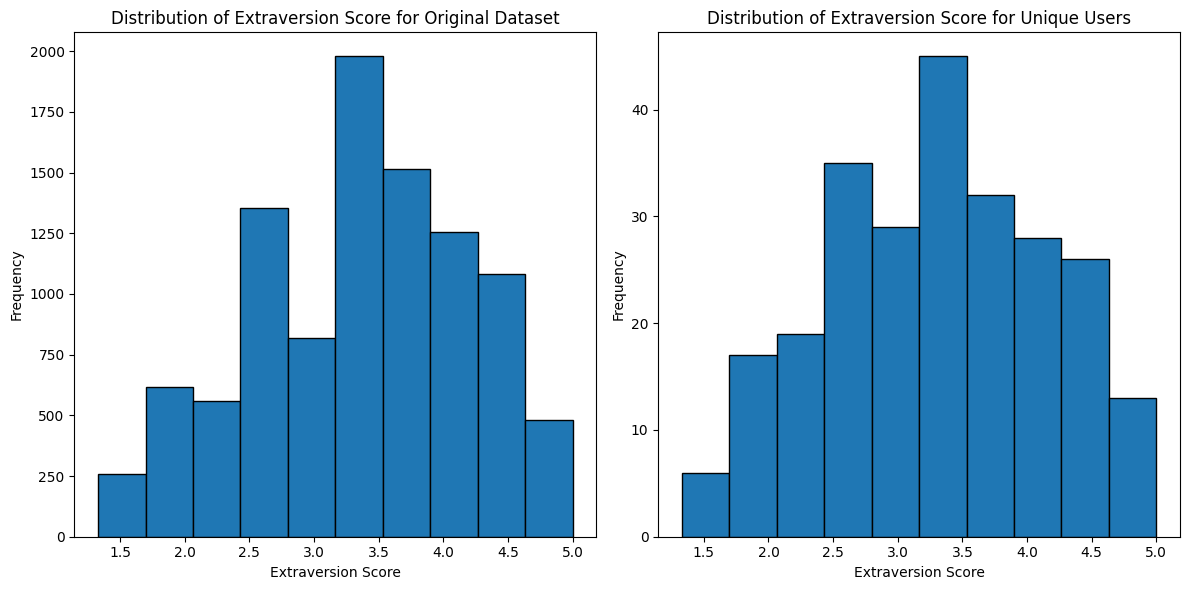

In [17]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(df['sEXT'], bins=10, edgecolor='black')
axs[0].set_xlabel('Extraversion Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Extraversion Score for Original Dataset')

axs[1].hist(unique_users['sEXT'], bins=10, edgecolor='black')
axs[1].set_xlabel('Extraversion Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Extraversion Score for Unique Users')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

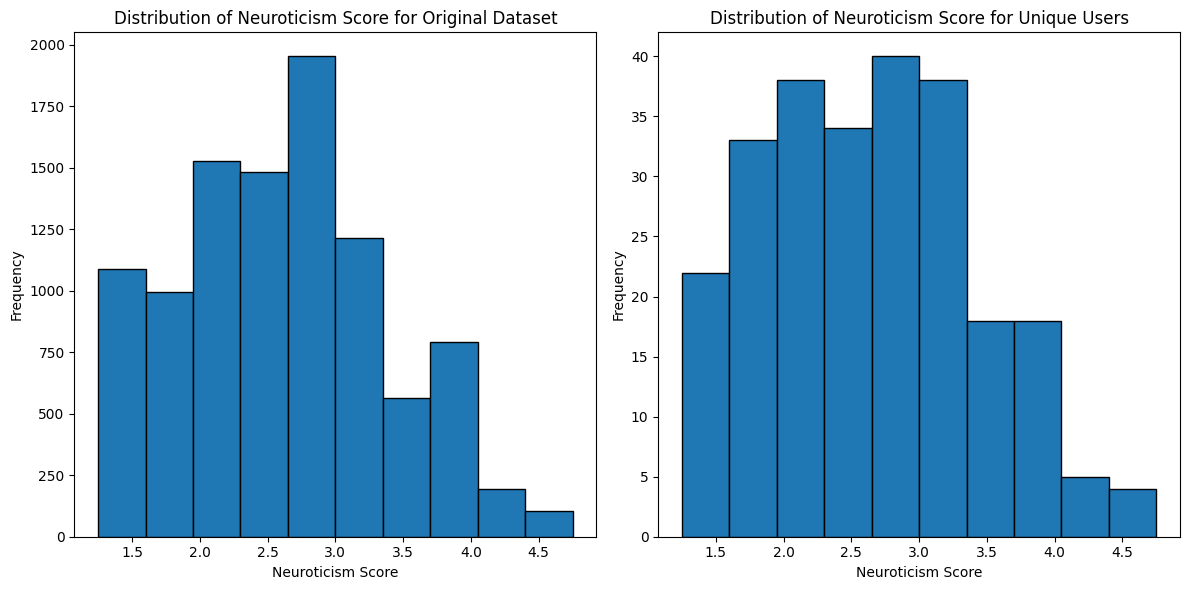

In [18]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(df['sNEU'], bins=10, edgecolor='black')
axs[0].set_xlabel('Neuroticism Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Neuroticism Score for Original Dataset')

axs[1].hist(unique_users['sNEU'], bins=10, edgecolor='black')
axs[1].set_xlabel('Neuroticism Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Neuroticism Score for Unique Users')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

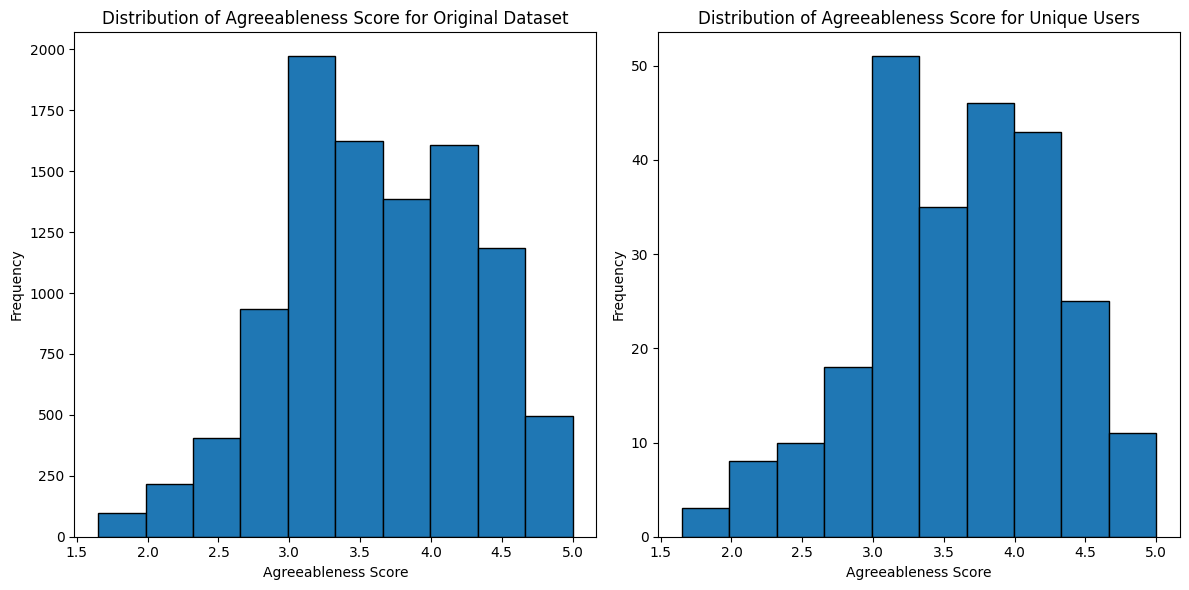

In [19]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(df['sAGR'], bins=10, edgecolor='black')
axs[0].set_xlabel('Agreeableness Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Agreeableness Score for Original Dataset')

axs[1].hist(unique_users['sAGR'], bins=10, edgecolor='black')
axs[1].set_xlabel('Agreeableness Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Agreeableness Score for Unique Users')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

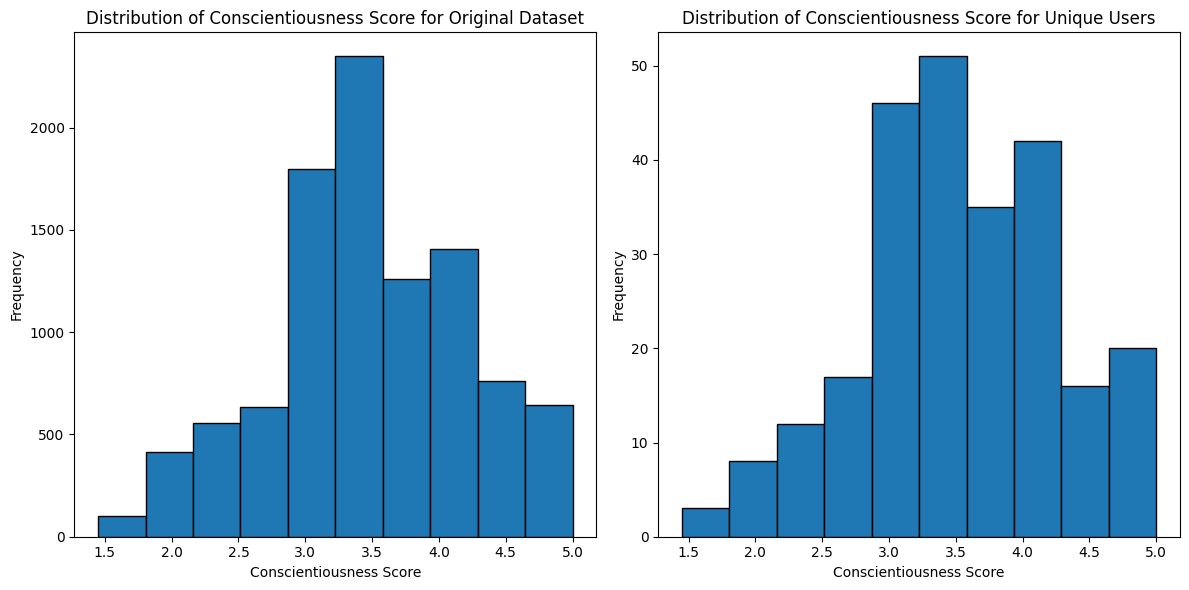

In [20]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(df['sCON'], bins=10, edgecolor='black')
axs[0].set_xlabel('Conscientiousness Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Conscientiousness Score for Original Dataset')

axs[1].hist(unique_users['sCON'], bins=10, edgecolor='black')
axs[1].set_xlabel('Conscientiousness Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Conscientiousness Score for Unique Users')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

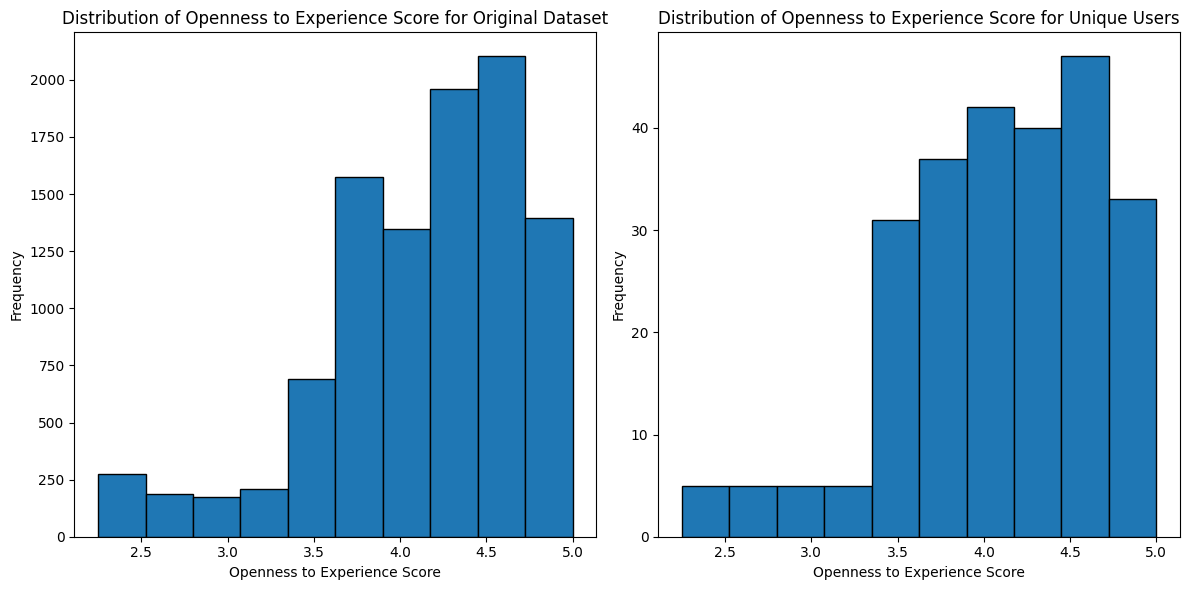

In [21]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(df['sOPN'], bins=10, edgecolor='black')
axs[0].set_xlabel('Openness to Experience Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Openness to Experience Score for Original Dataset')

axs[1].hist(unique_users['sOPN'], bins=10, edgecolor='black')
axs[1].set_xlabel('Openness to Experience Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Openness to Experience Score for Unique Users')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Ans: Distributions are largely the same for both datasets.

#### Use the `.describe()` method on `unique_users`:

In [22]:
unique_users.describe()

,sEXT,sNEU,sAGR,sCON,sOPN
count,250.000000,250.000000,250.000000,250.000000,250.00000
mean,3.292120,2.627240,3.600320,3.522920,4.07856
std,0.861368,0.776835,0.670758,0.740211,0.57506
min,1.330000,1.250000,1.650000,1.450000,2.25000
25%,2.662500,2.000000,3.150000,3.000000,3.75000
50%,3.300000,2.590000,3.660000,3.500000,4.15000
75%,4.000000,3.150000,4.100000,4.050000,4.50000
max,5.000000,4.750000,5.000000,5.000000,5.00000


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

Plots like histograms are useful for quickly identifying patterns, outliers or skewness in the data distributions while summary statistics provide specific insights into central tendency, variability of the data and more in numerical formats. For example, one can tell straight away from the histogram whether a distribution is skewed or not. However, for cases where the distributions are very similar visually, summary statistics are useful to have in aiding visual comprehension.

#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Barcharts of users per category per trait
- A seaborn correlation heatmap
- A seaborn pairplot

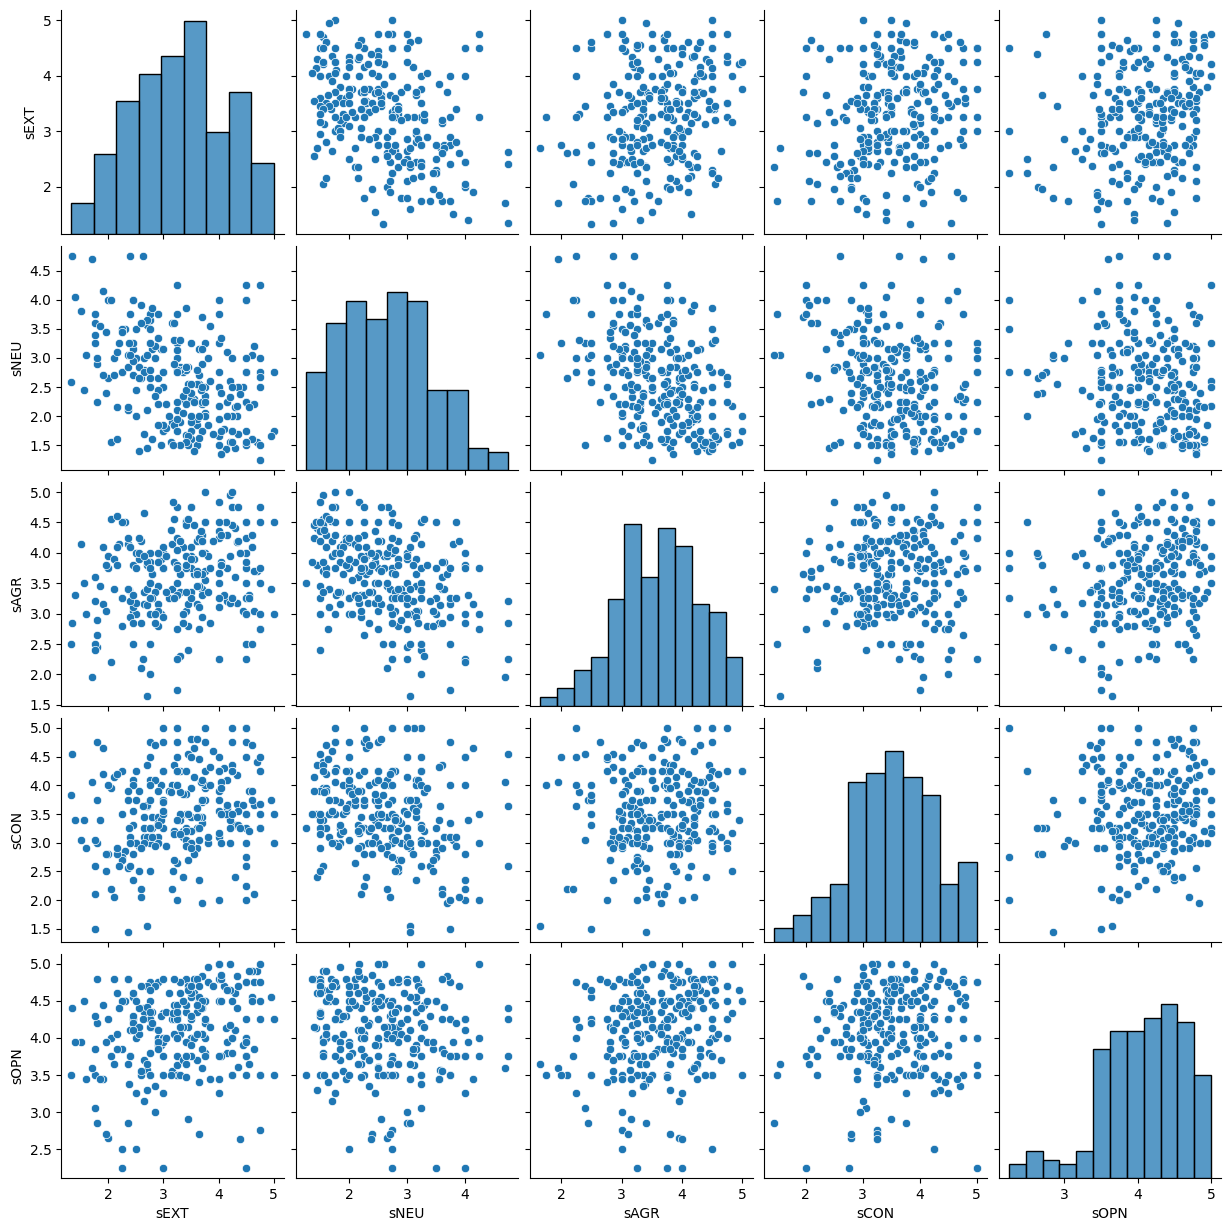

In [23]:
# Plot seaborn pairplot
sns.pairplot(unique_users)
plt.show()

---

## Exploring status length and word count based on personality

#### Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.

You'll need to use `groupby()` five separate times for this.

In [24]:
df.groupby('cOPN')[['status_length', 'status_word_count']].mean()

,status_length,status_word_count
cOPN,,
n,85.686298,15.450726
y,78.905143,14.205184


In [25]:
df.groupby('cCON')[['status_length', 'status_word_count']].mean()

,status_length,status_word_count
cCON,,
n,81.920149,14.709515
y,79.149034,14.308165


In [26]:
df.groupby('cEXT')[['status_length', 'status_word_count']].mean()

,status_length,status_word_count
cEXT,,
n,79.866655,14.394428
y,81.704918,14.702305


In [27]:
df.groupby('cAGR')[['status_length', 'status_word_count']].mean()

,status_length,status_word_count
cAGR,,
n,80.976769,14.616692
y,80.355800,14.444276


In [28]:
df.groupby('cNEU')[['status_length', 'status_word_count']].mean()

,status_length,status_word_count
cNEU,,
n,80.852396,14.548314
y,80.304278,14.486414


#### Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:

C:\Users\Razer\AppData\Local\Temp\ipykernel_28068\3289341320.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cOPN'] == category]['status_word_count'], label=category)
C:\Users\Razer\AppData\Local\Temp\ipykernel_28068\3289341320.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df

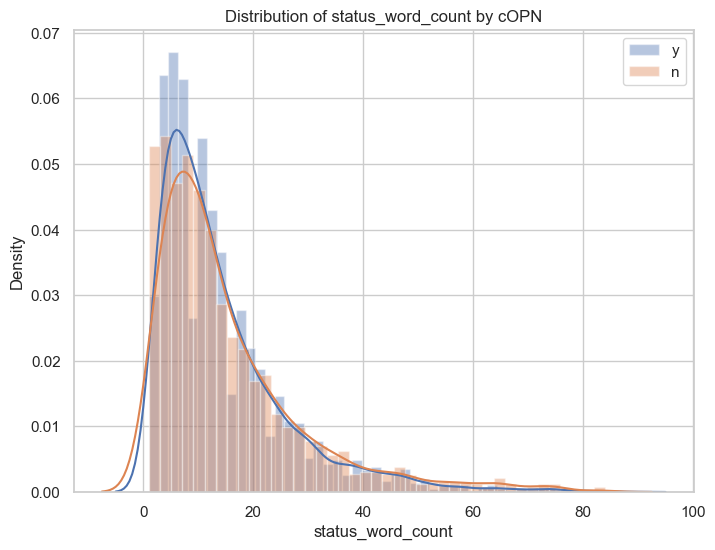

In [29]:
# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Use sns.distplot for each category in 'Category'
for category in df['cOPN'].unique():
    sns.distplot(df[df['cOPN'] == category]['status_word_count'], label=category)

plt.title('Distribution of status_word_count by cOPN')
plt.xlabel('status_word_count')
plt.legend()
plt.show()

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [30]:
# Instantiate CountVectorizer object with English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit CountVectorizer on the Facebook statuses and store the transformed data
transformed_data = count_vectorizer.fit_transform(df['STATUS'])

# Convert transformed data to a dense array
transformed_data_dense = transformed_data.toarray()

# Get feature names learned from the dataset
feature_names = count_vectorizer.get_feature_names_out()

# Convert transformed data to DataFrame
df2 = pd.DataFrame(transformed_data_dense, columns=feature_names)

df2.head()

,00,000,000ft,00am,00pm,01,02,02pm,03,0330,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Show the 15 most common words

In [31]:
# Calculate the total count of each word across all documents
word_counts = transformed_data.sum(axis=0)

# Convert the counts to a list of tuples (word, count)
word_count_tuples = [(word, word_counts[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]

# Sort the list of tuples by count in descending order
word_count_tuples_sorted = sorted(word_count_tuples, key=lambda x: x[1], reverse=True)

# Get the top 15 most common words
top_15_words = word_count_tuples_sorted[:15]

print(top_15_words)

[('propname', 1309), ('just', 717), ('day', 534), ('like', 506), ('time', 424), ('going', 414), ('today', 402), ('new', 386), ('work', 369), ('good', 354), ('got', 314), ('night', 312), ('love', 292), ('tomorrow', 277), ('know', 276)]


### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

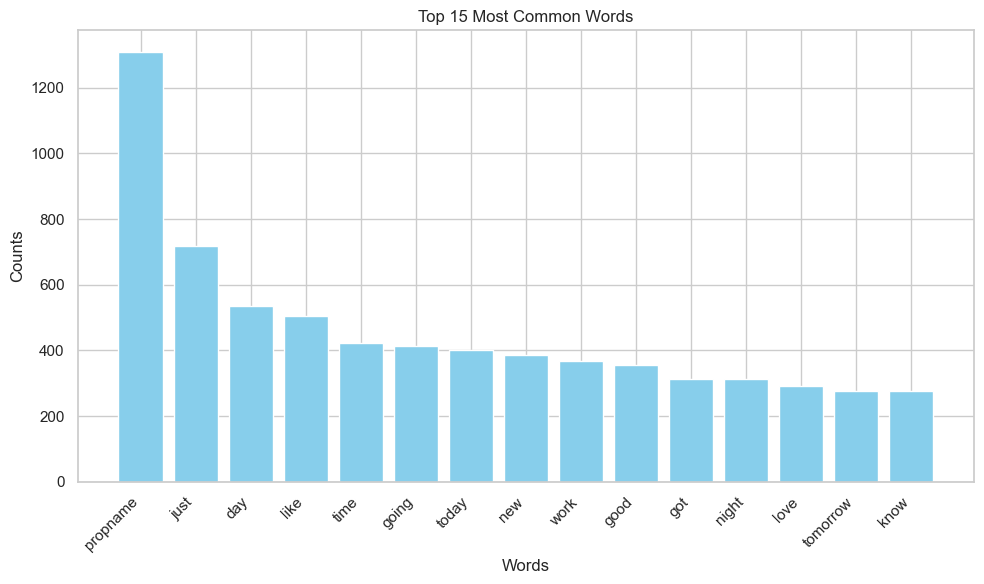

In [32]:
# Get the top 15 most common words and their counts
top_15_words = word_count_tuples_sorted[:15]
words, counts = zip(*top_15_words)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 15 Most Common Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [33]:
df['STATUS'][df['STATUS'].str.lower().str.contains('propname')].head(10)

6                                                                                                                                                                                                                                                         saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.
18                                                                                                                                                                                                                                                                                                         is tired. *PROPNAME*, let me go to sleep pl0x.
69                                                                                                                                                                                                              has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named

#### Provide a short explanation of what you believe `propname` to be:

Hint: The attached PDF also contains an explanation.

Ans: A string used to anonymise the proper name of each person in the facebook status.

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

#### Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:

In [34]:
text_and_scores = pd.concat([df, df2], axis=1)

In [35]:
text_and_scores.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,...,0,0,0,0,0,0,0,0,0,0
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,...,0,0,0,0,0,0,0,0,0,0
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,...,0,0,0,0,0,0,0,0,0,0
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,...,0,0,0,0,0,0,0,0,0,0
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,...,0,0,0,0,0,0,0,0,0,0


#### Show the 25 most common words for statuses from high-cAGR users:

In [36]:
high_cagr_df = text_and_scores[text_and_scores['cAGR'] == 'y']
word_counts_high_cagr = high_cagr_df.drop(columns=['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT', 'cNEU', 'cAGR', 'cOPN', 'cCON', 'DATE', 'status_length', 'status_word_count'])
word_counts_high_cagr.columns

Index(['00', '000', '000ft', '00am', '00pm', '01', '02', '02pm', '03', '0330',
       ...
       'équipe', 'étais', 'était', 'étant', 'état', 'été', 'être', 'østersund',
       'últimas', 'últimos'],
      dtype='object', length=15183)

In [37]:
word_counts_high_cagr.sum().sort_values(ascending=False).head(25)

propname    699
just        402
day         297
like        280
time        221
today       219
work        206
good        201
going       200
new         194
love        172
happy       165
night       161
know        157
got         157
people      156
tomorrow    153
life        140
home        131
tonight     129
really      127
don         119
want        108
weekend     105
ll          103
dtype: int64

#### Show the 25 most common words for statuses from low-cAGR users:

In [38]:
low_cagr_df = text_and_scores[text_and_scores['cAGR'] == 'n']
word_counts_low_cagr = low_cagr_df.drop(columns=['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT', 'cNEU', 'cAGR', 'cOPN', 'cCON', 'DATE', 'status_length', 'status_word_count'])
word_counts_low_cagr.sum().sort_values(ascending=False).head(25)

propname    610
just        315
day         237
like        226
going       214
time        203
new         192
today       183
work        163
got         157
good        153
night       151
home        136
don         134
tonight     127
tomorrow    124
life        120
love        120
really      119
know        119
people      112
think       110
want        109
happy       107
week         98
dtype: int64

### (BONUS) Most common bigrams:

This is a bonus section and not required.

Find the 10 most common bigrams in the dataset.

### (BONUS) Most common trigrams:

This is a bonus section and not required.

Find the 10 most common trigrams in the dataset.

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [exploratory vs. explanatory analysis](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as _explanatory_. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.